## Fitted analysis

In this notebook, I attempt to replicate many of the figures from the Linderman paper `Hierarchical recurrent state space models reveal discrete and continuous dynamics of neural activity in C. elegans`.

In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import ssm
import pickle
import os
import seaborn as sns
from sklearn import cluster as cl
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import pandas as pd


%matplotlib inline

from matplotlib.colors import ListedColormap

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = ListedColormap(colors)

# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)
    return ax

In [2]:
DATA_PATH = '../data/processed/lem_95-100_20210103143715/'
IMAGES_PATH = '../images/'
files = os.listdir(DATA_PATH)
all_data = [pickle.load(open(DATA_PATH + x,'rb')) for x in files]
models = [d[2] for x in all_data for d in x]
posteriors = [d[1] for x in all_data for d in x]

Y_PATH = '../scripts/gcp/data/train_test_95-100.pkl'
[y_train, y_test] = pickle.load(open(Y_PATH, 'rb'))

In [3]:
m = models[0]
p = posteriors[0]
N = 137
K = 2
D = 5
cmap_limited = ListedColormap(colors[0:D])

In [4]:
p_x = p.mean_continuous_states[0]

p_z = m.most_likely_states(p_x, y_train)

p_y = m.smooth(p_x,y_train)

normed_y = normalize(p_y,axis=0,norm='l1')

In [5]:
sum_of_squared_distances = []
silhouette_scores = []
K = range(2,15)
for k in K:
    k_means = cl.KMeans(n_clusters=k)
    pred = k_means.fit_predict(normed_y.T)
    sum_of_squared_distances.append(k_means.inertia_)
    silhouette_scores.append(silhouette_score(normed_y.T,pred))

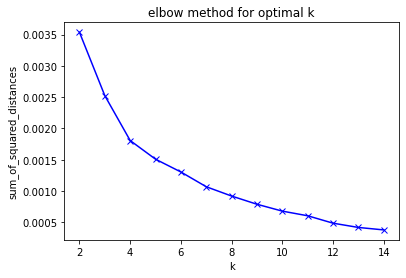

In [6]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

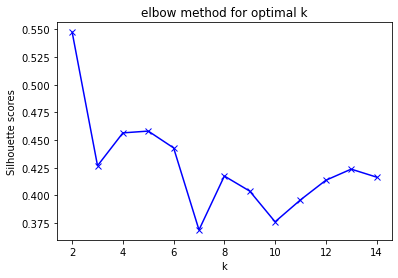

In [7]:
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette scores')
plt.title('elbow method for optimal k')
plt.show()

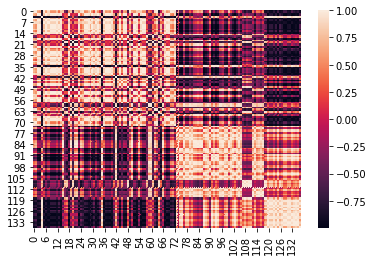

In [8]:
N_cl = 5
c = cl.KMeans(n_clusters=N_cl)
c.fit(normed_y.T)

c_p = c.predict(normed_y.T)

idx = np.argsort(c_p)

sns.heatmap(np.corrcoef(normed_y[:,idx].T))
plt.show()

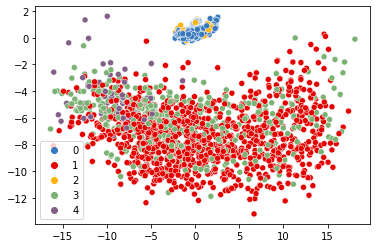

In [9]:
sns.scatterplot(x=p_x[:,0], y=p_x[:,1],
                hue=p_z,palette=cmap_limited)
plt.show()

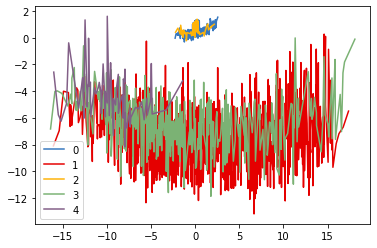

In [207]:
sns.lineplot(x=p_x[:,0], y=p_x[:,1],
                hue=p_z,palette=cmap_limited)
plt.show()

<AxesSubplot:ylabel='Count'>

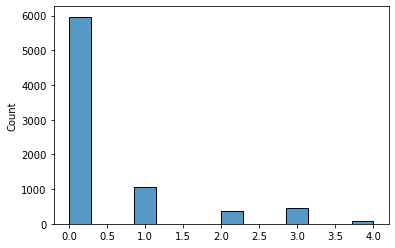

In [208]:
sns.histplot(p_z)

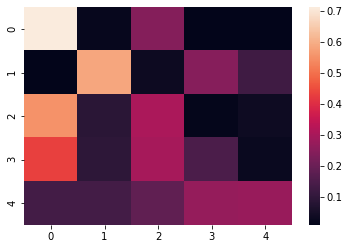

In [209]:
sns.heatmap(m.transitions.transition_matrix)
plt.show()

TODO: Could use average run length encoding of each state - should look at other digital information theory metrics

In [10]:
from itertools import groupby
from operator import itemgetter

clust_locs = []
for clust in range(N_cl):
    for k,v in groupby(enumerate(np.array(sorted(c_p)) == clust),key=itemgetter(1)):
        if k:
            v = list(v)
            clust_locs.append(v[-1][0])

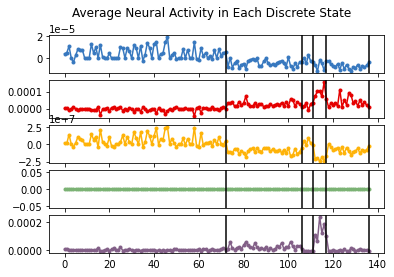

In [11]:
fig, axs = plt.subplots(D, sharex = True)
fig.suptitle('Average Neural Activity in Each Discrete State')

p_y_idx = normed_y[:,idx]
for state in range(D):
    runs = []
    for k,v in groupby(enumerate(p_z == state),key=itemgetter(1)):
        if k:
            v = list(v)
            runs.append([v[0][0],v[-1][0]])

    diff_rates = np.zeros((len(runs),N))
    for i,run in enumerate(runs):
        for neuron in range(N):
            diff_rates[i,neuron] = p_y_idx[run[1],neuron] - p_y_idx[run[0],neuron]
    
    axs[state].plot(diff_rates.mean(axis=0),color=colors[state], marker='.')
    for xc in clust_locs:
        axs[state].axvline(x=xc,color="black")

In [212]:
clust_locs

[30, 38, 39, 47, 50, 55, 136]

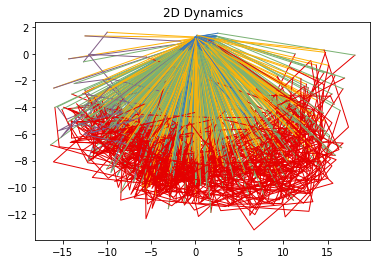

In [218]:
fig,ax = plt.subplots()
plot_trajectory(p_z, p_x, ax=ax)
plt.title("2D Dynamics")
plt.show()

This looks super choppy. I wonder if that is because we don't have enough continuous states? I'd like to take a look at these graphics with higher number of discrete states and continuous states.

In [12]:
N = y_train.shape[1]
K = 3 # discrete states
D = 2 # continuous states, dimensionality of latent state

cmap_limited = ListedColormap(colors[0:K])

In [13]:
print("Fitting SLDS with Laplace-EM")
slds_lem = ssm.SLDS(N, K, D, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))
slds_lem.initialize(y_train)

q_lem_elbos, q_lem = slds_lem.fit(y_train, method="laplace_em",
                              variational_posterior="structured_meanfield",
                              num_iters=20, initialize=False, alpha=0)
q_lem_x = q_lem.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
q_lem_z = slds_lem.most_likely_states(q_lem_x, y_train)

# Smooth the data under the variational posterior
q_lem_y = slds_lem.smooth(q_lem_x, y_train)

normed_y = normalize(q_lem_y,axis=0,norm='l1')

Fitting SLDS with Laplace-EM


  0%|          | 0/20 [00:00<?, ?it/s]

TODO: need to develop CV algorithm for finding best K,D for given set of neurons

TODO: build hierarchical extensions for rSLDS

Kind of done: check which 2 dimensions of x explain most variance (I've been assuming it's first 2, but might not be the case)

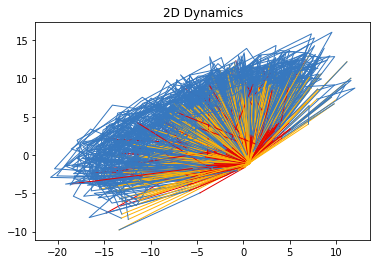

In [14]:
fig,ax = plt.subplots()
plot_trajectory(q_lem_z, q_lem_x, ax=ax)
plt.title("2D Dynamics")
plt.show()

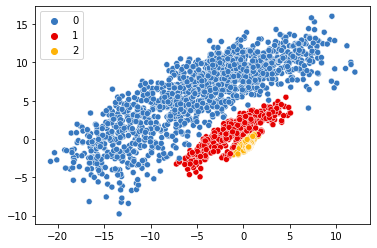

In [15]:
sns.scatterplot(x=q_lem_x[:,0], y=q_lem_x[:,1],
                hue=q_lem_z,palette=cmap_limited)
plt.show()

TODO: how to visualize high-dimensional vectors?

One of way is likely to look at each combination of components

In [337]:
# Attempt to find top 2 dimensions of continuous states that explain the most variance

# top_N_dim = 2
# corrs = np.zeros((D,N))
# for d in range(D):
#     for n in range(N):
#         corrs[d,n] = np.corrcoef(q_lem_x.T[d,:], q_lem_y.T[n,:])[0,1]
        
# np.argpartition(np.abs(corrs.mean(axis=1)), -top_N_dim)[-top_N_dim:]

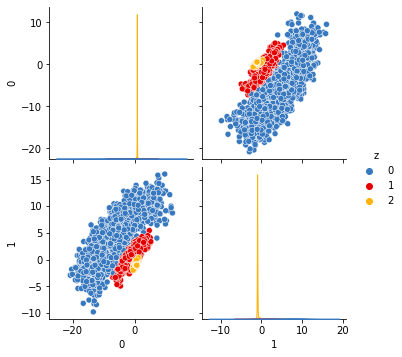

In [16]:
pairplot = sns.pairplot(pd.concat([pd.DataFrame(q_lem_x),pd.Series(q_lem_z).rename('z')],axis=1),
                        hue="z",palette=cmap_limited.colors)

In [339]:
pairplot.savefig(IMAGES_PATH + f'pairplot_N-{N}_K-{K}_D-{D}.png')

TODO: Could also use a plot showing proportion of each state at each time point, relative to each PBE